<a href="https://colab.research.google.com/github/John-Bugler/Statistics-data-analysis-google-colab-/blob/main/data_valuo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

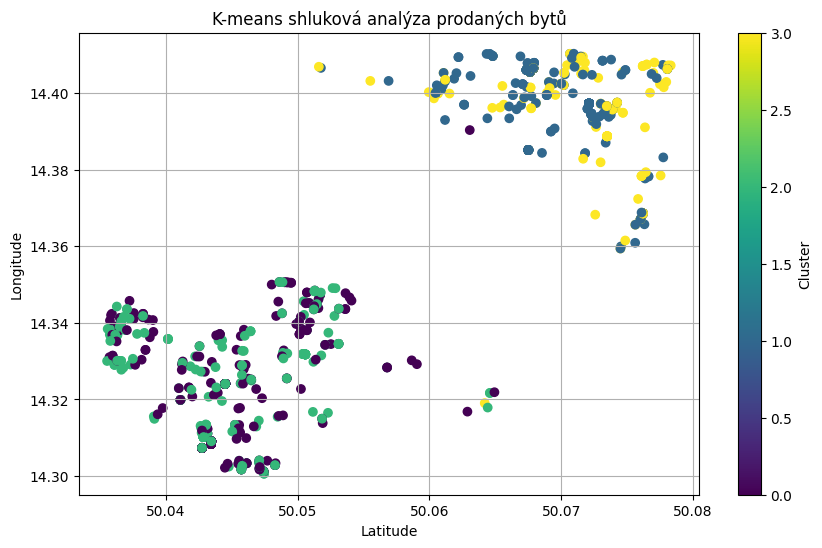

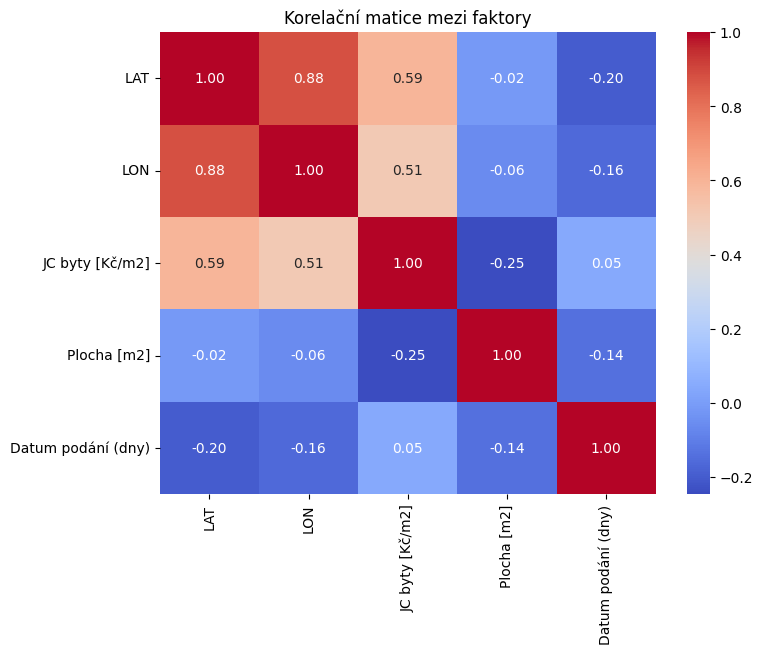

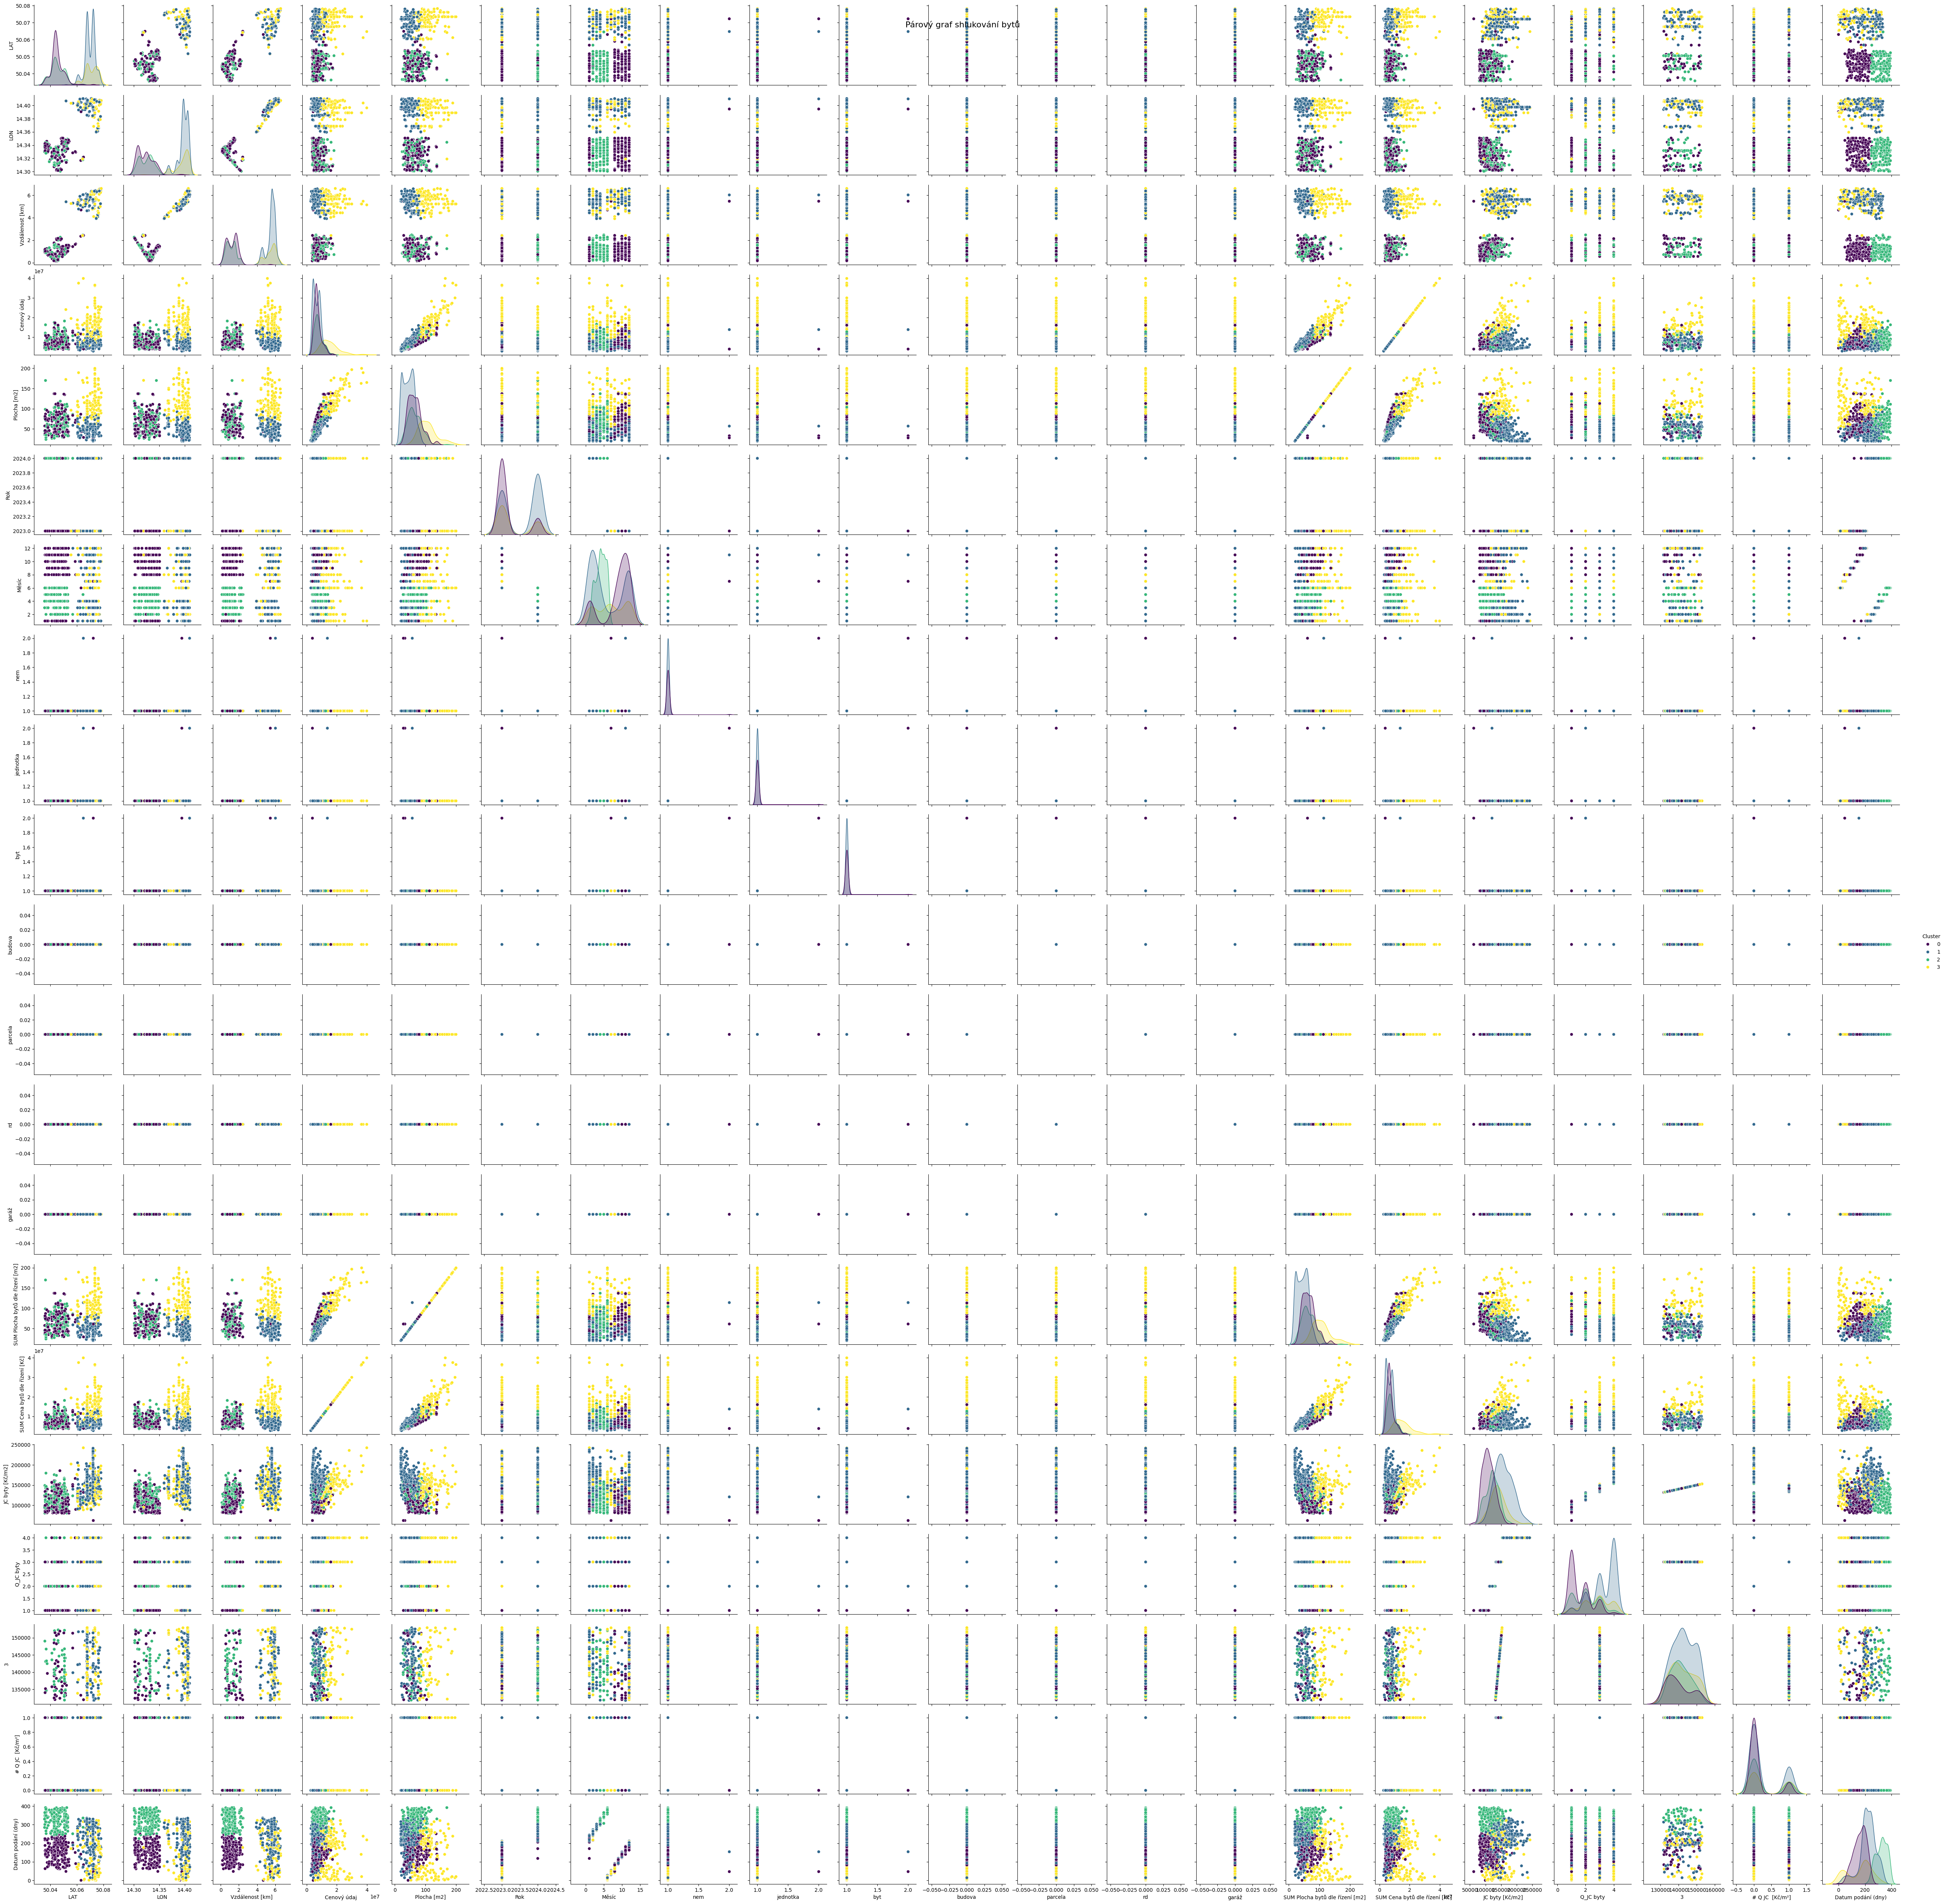


📊 Výsledky modelů:
Lineární regrese: R² = 0.384, MSE = 707195251.83
Random Forest: R² = 0.596, MSE = 463949268.64


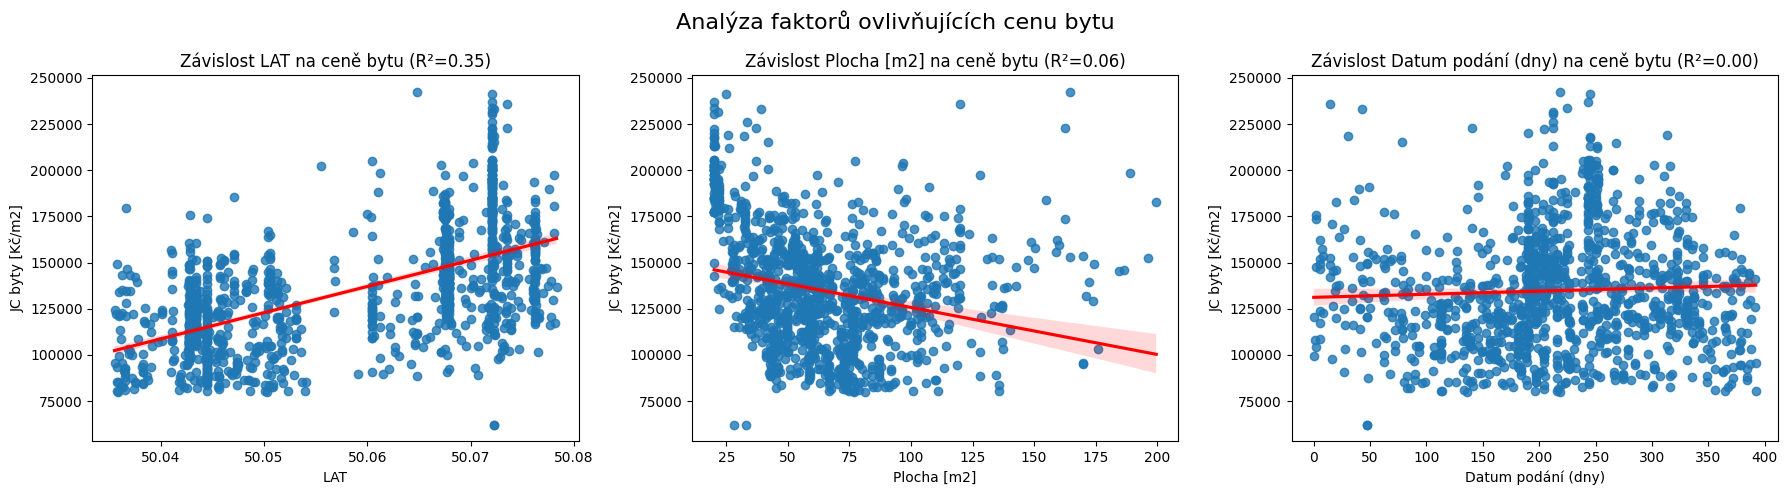

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def analyze_real_estate_data(file_path, enable_visuals=True):
    """
    Analyzuje data o cenách bytů v Praze, provádí shlukovou analýzu a predikuje ceny.
    :param file_path: Cesta k CSV souboru obsahujícímu vstupní data.
    :param enable_visuals: Ovládání vizualizací pro rychlejší běh v Excelu.
    """
    # 1️⃣ Načtení dat
    df = pd.read_excel(file_path, parse_dates=['Datum podání'])
    # dayfirst argument is deprecated, use dayfirst within to_datetime
    df['Datum podání'] = pd.to_datetime(df['Datum podání'], dayfirst=True)
    df['Datum podání (dny)'] = (df['Datum podání'] - df['Datum podání'].min()).dt.days

    # Výběr relevantních sloupců
    features = ['LAT', 'LON', 'JC byty [Kč/m2]', 'Plocha [m2]', 'Datum podání (dny)']
    df = df.dropna(subset=features)

    # 2️⃣ Normalizace dat pro K-means
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    # 3️⃣ Shluková analýza (K-means)
    k = 4
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=300)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    if enable_visuals:
        # 4️⃣ Vizualizace shluků podle polohy
        plt.figure(figsize=(10, 6))
        plt.scatter(df['LAT'], df['LON'], c=df['Cluster'], cmap='viridis', marker='o')
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title('K-means shluková analýza prodaných bytů')
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.savefig("shlukova_analyza.png")
        plt.show()

        # 5️⃣ Korelační analýza
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Korelační matice mezi faktory')
        plt.savefig("korelacni_matrice.png")
        plt.show()

        # 6️⃣ Párový graf pro shlukování (omezený vzorek pro rychlost)
        sampled_df = df.sample(n=min(5000, len(df)), random_state=42)
        sns.pairplot(sampled_df, hue='Cluster', diag_kind='kde', palette='viridis')
        plt.suptitle('Párový graf shlukování bytů', fontsize=16)
        plt.savefig("parovy_graf_shlukovani.png")
        plt.show()

    # 7️⃣ Predikce cen bytů
    X = df[['LAT', 'LON', 'Plocha [m2]', 'Datum podání (dny)']]
    y = df['JC byty [Kč/m2]']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model 1: Lineární regrese
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Model 2: Random Forest
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_reg.fit(X_train, y_train)
    y_pred_rf = rf_reg.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)

    print("\n📊 Výsledky modelů:")
    print(f"Lineární regrese: R² = {r2_lr:.3f}, MSE = {mean_squared_error(y_test, y_pred_lr):.2f}")
    print(f"Random Forest: R² = {r2_rf:.3f}, MSE = {mean_squared_error(y_test, y_pred_rf):.2f}")

    if enable_visuals:
        # 8️⃣ Grafy závislostí faktorů na ceně včetně R²
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        factors = ['LAT', 'Plocha [m2]', 'Datum podání (dny)']

        for i, factor in enumerate(factors):
            sns.regplot(ax=axes[i], x=df[factor], y=df['JC byty [Kč/m2]'], line_kws={'color': 'red'})
            r2 = r2_score(df['JC byty [Kč/m2]'], LinearRegression().fit(df[[factor]], df['JC byty [Kč/m2]']).predict(df[[factor]]))
            axes[i].set_title(f'Závislost {factor} na ceně bytu (R²={r2:.2f})')
            axes[i].set_xlabel(factor)
            axes[i].set_ylabel('JC byty [Kč/m2]')

        plt.suptitle('Analýza faktorů ovlivňujících cenu bytu', fontsize=16)
        plt.tight_layout()
        plt.savefig("zavislosti_faktoru.png")
        plt.show()

    return df

# 📌 Použití funkce s daty ze souboru
df = analyze_real_estate_data("/content/sample_data/valuo test data.xlsx", enable_visuals=True)
